In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root_path = '/content/drive/path/'

!mkdir data
!cp '/content/drive/path/'* data

mkdir: cannot create directory ‘data’: File exists


In [0]:
import numpy as np
import pandas as pd 
import scipy.sparse
import matplotlib.pyplot as plt

In [0]:
test = pd.read_csv('data/test_pairs.csv')
test.head()


,pairId,FirstId,SecondId
0,0,1427,8053
1,1,17044,7681
2,2,19237,20966
3,3,8005,20765
4,4,16837,599


##Data analysis

We are ploting data, **FirstId** in x axis and **SecondId** in y axis.

We can see there're some patterns. Clearly, there is a group of pairs with **SecondId > FirstId** distinguishable from other pairs.

Text(0, 0.5, 'SecondID')

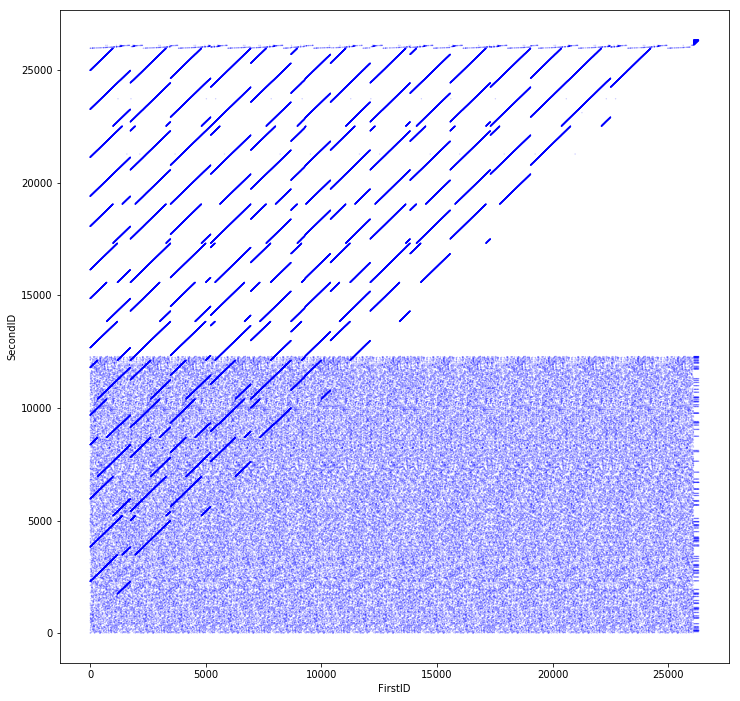

In [0]:
plt.figure(figsize=(12,12))
plt.scatter(test.FirstId,test.SecondId,edgecolor = 'none',alpha = 0.2, s=2, c='b')
plt.xlabel('FirstID')
plt.ylabel('SecondID')

#First guess
So, we are setting **Prediction** to **1** for al pairs having **SecondId > FirstId** and let's see what happens.

In [0]:
test["Prediction"] = 0
test.loc[test.SecondId > test.FirstId, "Prediction"] = 1
test.head(20)

,pairId,FirstId,SecondId,Prediction
0,0,1427,8053,1
1,1,17044,7681,0
2,2,19237,20966,1
3,3,8005,20765,1
4,4,16837,599,0
5,5,3657,12504,1
6,6,2836,7582,1
7,7,6136,6111,0
8,8,23295,9817,0
9,9,6621,7672,1


We check the percentage of pairs predicted as **1** and the result is 61.69%. Since we know actual value is 50%, we know our prediction is wrong, but we can use it as an estimation for the validity of our guess.

In [0]:
test[test.Prediction == 1].shape[0] / test.shape[0]

0.6169529236195903

In [0]:
guess_1 = pd.DataFrame(test, columns = ['pairId', 'Prediction']) 
guess_1.head(10)

,pairId,Prediction
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0
5,5,1
6,6,1
7,7,0
8,8,0
9,9,1


In [0]:
guess_1.to_csv('submission_guess_1.csv', index=False)

##First guess results

We submit our prediction and..

**`Your accuracy score is 0.883047. It seems too low, try one more time.`**

An accuracy of 0.88 doing almost nothing! We have something.

##Let's get a closer look

(10000, 15000)

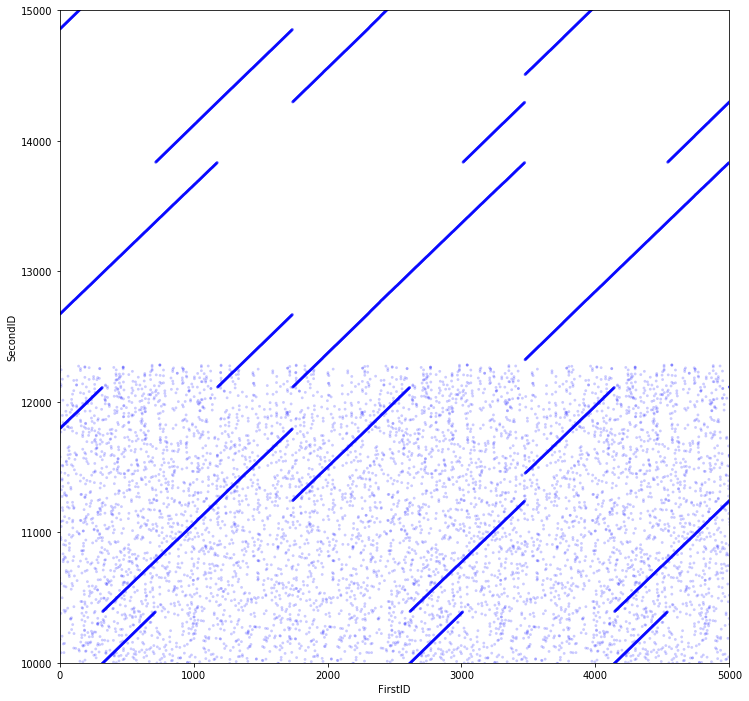

In [0]:
plt.figure(figsize=(12,12))
plt.scatter(test.FirstId,test.SecondId,edgecolor = 'none',alpha = 0.2, s=8, c='b')
plt.xlabel('FirstID')
plt.ylabel('SecondID')
plt.xlim(0, 5000)
plt.ylim(10000, 15000)

(10000, 10400)

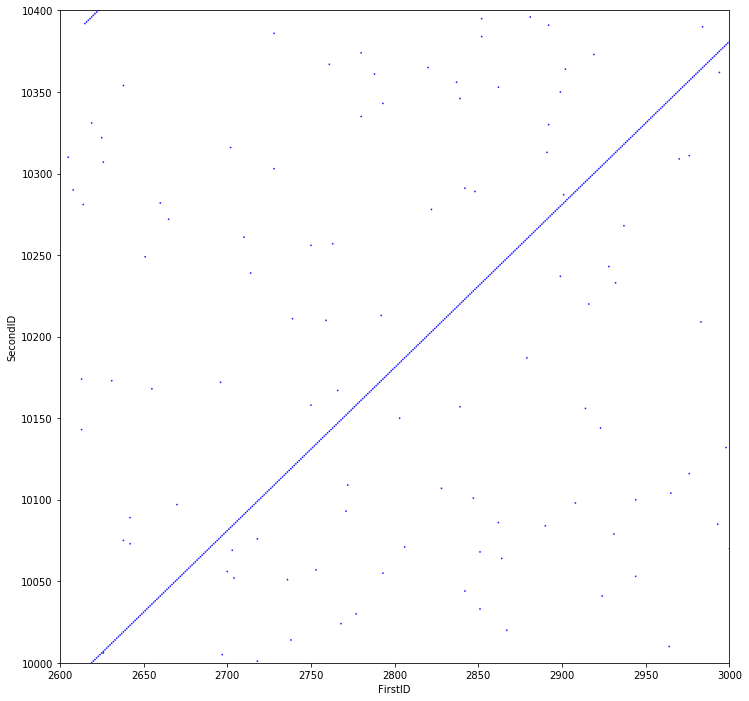

In [0]:
plt.figure(figsize=(12,12))
plt.scatter(test.FirstId,test.SecondId,edgecolor = 'none',alpha = 0.9, s=3, c='b')

plt.xlabel('FirstID')
plt.ylabel('SecondID')
plt.xlim(2600, 3000)
plt.ylim(10000, 10400)

(10050, 10150)

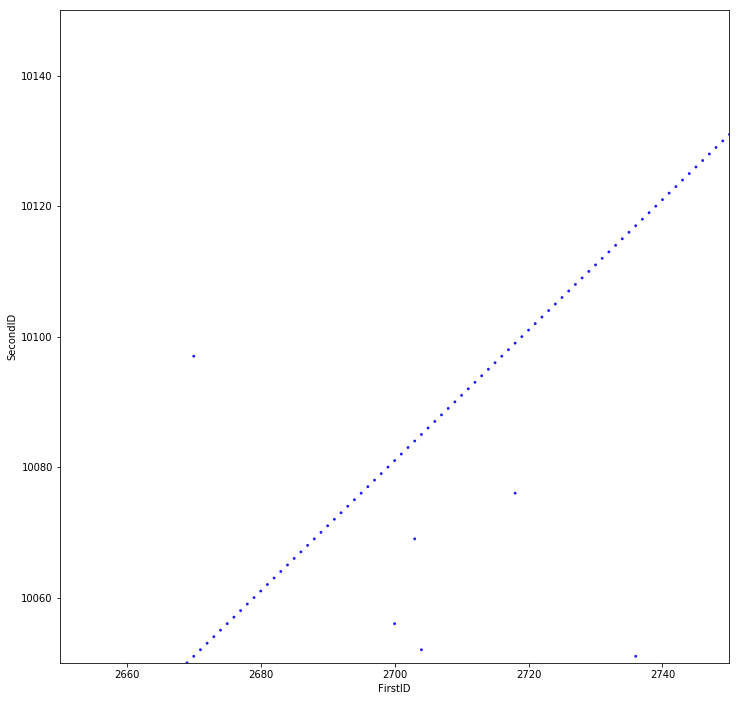

In [0]:
plt.figure(figsize=(12,12))
plt.scatter(test.FirstId,test.SecondId,edgecolor = 'none',alpha = 0.9, s=8, c='b')

plt.xlabel('FirstID')
plt.ylabel('SecondID')
plt.xlim(2650, 2750)
plt.ylim(10050, 10150)

OK, I suspect that the person who prepared the data took consecutive series of photos ID as similar pairs. So, the pair points in these clearly visible lines are related photos (*Prediction = 1*).

Also, all the points in these lines meet *SecondId = FirstId + VALUE*. So, if we create a new feature, **diff**, as the difference between **FirstId** and **SecondId** all points in these lines should have the same value for this atribute. We are sorting by this new atribute **diff**.

Also, we are creating two more features: **diff1** and **diff2** as the difference of **FirstId** and **SecondId** values, respectively, between current row and previous row once ordered by **diff** feature.

In [0]:
X1 = 2650
X2 = 2750
Y1 = 10050
Y2 = 10150

test2 = test[test.SecondId > test.FirstId].sort_values(by=['FirstId']).copy()
test2.reset_index(inplace=True, drop=True)
test2["diff"] = abs(test2.FirstId - test2.SecondId)
test2 = test2.sort_values(by=['diff','FirstId']).reset_index()

test2["diff1"] = test2.FirstId - test2.shift(1).FirstId
test2["diff2"] = test2.SecondId - test2.shift(1).SecondId

test2.loc[(test2.FirstId >= X1) & (test2.FirstId <= X2) & (test2.SecondId > Y1) & (test2.SecondId < Y2)]


,index,pairId,FirstId,SecondId,Prediction,diff,diff1,diff2
120110,54352,339223,2736,10051,1,7315,2137.0,2137.0
120204,53765,54417,2704,10052,1,7348,1536.0,1536.0
120223,53673,210173,2700,10056,1,7356,-1316.0,-1315.0
120228,54016,171687,2718,10076,1,7358,1115.0,1115.0
120250,53737,17063,2703,10069,1,7366,2469.0,2469.0
121037,53127,6268,2670,10051,1,7381,1.0,1.0
121038,53151,131961,2671,10052,1,7381,1.0,1.0
121039,53166,115906,2672,10053,1,7381,1.0,1.0
121040,53177,234563,2673,10054,1,7381,1.0,1.0
121041,53198,192066,2674,10055,1,7381,1.0,1.0


We can see that consecutive pairs having the same **diff** value meet another condition, **diff1** and **diff2** are equal to **1**. That is, one valid pair ID values are *X* and *Y*, the next valid pair will have ID values *X + 1* and *Y + 1*.

So, we are setting **Prediction = 1** to all pairs having **diff1 = 1 AND diff2 = 1** and see what happens.

If we plot values with **Prediction = 1** we can see we have successfully isolated most of the points that we could see in initial analysis.

Text(0, 0.5, 'SecondID')

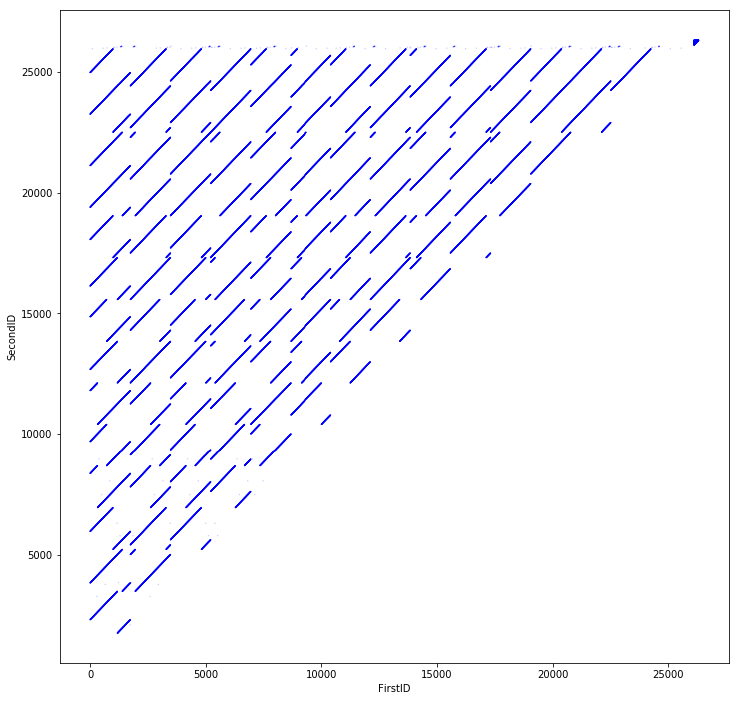

In [0]:
plt.figure(figsize=(12,12))
test3 = test2.loc[(test2.diff1 == 1) & (test2.diff2 == 1)]
plt.scatter(test3.FirstId,test3.SecondId,edgecolor = 'none',alpha = 0.2, s=2, c='b')
plt.xlabel('FirstID')
plt.ylabel('SecondID')

#Second guess

OK, we are setting **Prediction = 1** to all pairs having **diff1 = 1 AND diff2 = 1** and see what happens.


In [0]:
guess_2 = pd.read_csv('data/test_pairs.csv')

guess_2['Prediction'] = 0

guess_2["diff"] = abs(guess_2.FirstId - guess_2.SecondId)
guess_2 = guess_2.sort_values(by=['diff','FirstId']).reset_index()

guess_2["diff1"] = guess_2.FirstId - guess_2.shift(1).FirstId
guess_2["diff2"] = guess_2.SecondId - guess_2.shift(1).SecondId

guess_2.loc[(guess_2.diff1 == 1) & (guess_2.diff2 == 1) & (guess_2.SecondId > guess_2.FirstId), 'Prediction'] = 1

Text(0, 0.5, 'SecondID')

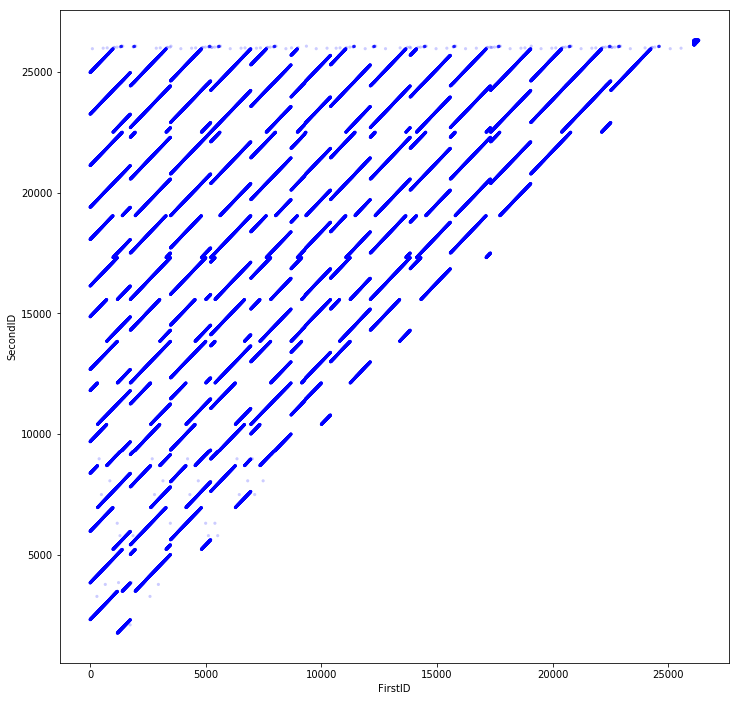

In [0]:
plt.figure(figsize=(12,12))
plt.scatter(guess_2.loc[guess_2['Prediction'] == 1].FirstId, guess_2.loc[guess_2['Prediction'] == 1].SecondId, edgecolor = 'none',alpha = 0.2, s=10, c='b')
plt.xlabel('FirstID')
plt.ylabel('SecondID')

In [0]:
pd.DataFrame(guess_2, columns = ['pairId', 'Prediction']).to_csv('submission_guess_2.csv', index=False)

##Second guess results

We submit the prediction and...

**`Well done! Your accuracy score is 0.989331 `**

Woah! Almost 0.99!!

We could stop now, but I realised that getting only pairs with **diff1** and **diff2** equal to **1** I'm leaving out "the first point" for each line, since there is no relation between this "first point" and pair in previous row. So, I'm creating two more features, **diff3** and **diff4** as the difference of **FirstId** and **SecondId** values, respectively, between current row and next row once ordered by **diff** feature. 

#Third guess

OK, we are creating new **diff3** and **diff4** feautres, and the we're setting **Prediction = 1** to all pairs having **diff1 = 1 AND diff2 = 1** and to all pairs having **diff3 = -1 AND diff4 = -1**.

In [0]:
guess_3 = pd.read_csv('data/test_pairs.csv')

guess_3['Prediction'] = 0

guess_3["diff"] = abs(guess_3.FirstId - guess_3.SecondId)
guess_3 = guess_3.sort_values(by=['diff','FirstId']).reset_index()

guess_3["diff1"] = guess_3.FirstId - guess_3.shift(1).FirstId
guess_3["diff2"] = guess_3.SecondId - guess_3.shift(1).SecondId
guess_3["diff3"] = guess_3.FirstId - guess_3.shift(-1).FirstId
guess_3["diff4"] = guess_3.SecondId - guess_3.shift(-1).SecondId

guess_3.loc[(guess_3.diff1 == 1) & (guess_3.diff2 == 1) & (guess_3.SecondId > guess_3.FirstId), 'Prediction'] = 1
guess_3.loc[(guess_3.diff3 == -1) & (guess_3.diff4 == -1) & (guess_3.SecondId > guess_3.FirstId), 'Prediction'] = 1

Text(0, 0.5, 'SecondID')

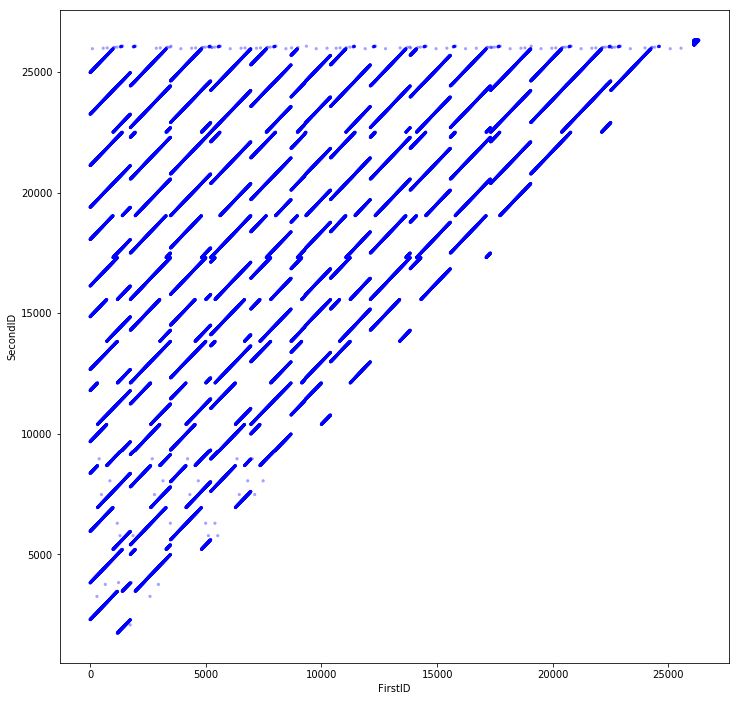

In [0]:
plt.figure(figsize=(12,12))
plt.scatter(guess_3.loc[guess_3['Prediction'] == 1].FirstId, guess_3.loc[guess_3['Prediction'] == 1].SecondId, edgecolor = 'none',alpha = 0.2, s=10, c='b')
plt.xlabel('FirstID')
plt.ylabel('SecondID')

In [0]:
pd.DataFrame(guess_3, columns = ['pairId', 'Prediction']).to_csv('submission_guess_3.csv', index=False)

##Third guess results

We submit our prediction and...

**`Well done! Your accuracy score is 0.995344`**

OK, enought without having properly trained a model :)
